# Multi-Input Multi-Output (MIMO)

In [1]:
#%pylab inline # to show plots within notebook

In [2]:
"""
Multi-Input Multi-Output (MIMO) Channels
Single User

@author: Hassan Ghozlan
"""

from __future__ import division #makes float division default. for integer division, use //. e.g. 7//4=1

import matplotlib
#matplotlib.use('Agg') # force matplotlib to not use any Xwindows backend.
# fixes the error "no display name and no $DISPLAY environment variable"
# when code is run on Amazon Elastic Cloud Compute (EC2)

from numpy import *
from matplotlib.pyplot import *
from numpy.fft import ifft, fftshift, fft
from numpy.linalg import svd
from numpy.linalg import eigvalsh #eigvalsh : eigenvalues of a symmetric or Hermitian (conjugate symmetric)

from numpy.random import randint, standard_normal
from numpy.linalg import det
from numpy.linalg import inv # inverse
from numpy.linalg import pinv # psuedo-inverse

# MIMO Channel (Single User)

$$
\newcommand{\x}{\textbf{x}}
\newcommand{\y}{\textbf{y}}
\newcommand{\GM}{\textbf{G}}
\newcommand{\HM}{\textbf{H}}
\newcommand{\rv}{\textbf{r}}
\newcommand{\n}{\textbf{n}}
\newcommand{\z}{\textbf{z}}
\newcommand{\g}{\textbf{g}}
$$


The received signal is
$$ \rv = \HM \x + \n $$

where $\HM$ is $n_r \times n_t$. 
Suppose $n_r = n_t$.

# Optimal Receiver

Let $\y = \rv$. 
The information rate of the **optimal** receiver is
$$ R_{\text{opt}} = I(\x;\y) = \log(\det(\Sigma_r)) - \log(\det(\Sigma_{r|x})) $$
where
$$ \Sigma_r = \HM \Sigma_x \HM^\dagger + \Sigma_n $$
and
$$ \Sigma_{r|x} = \Sigma_n $$

Note that

$$\log(\det(\Sigma)) = \log(\prod_i \lambda_i) = \sum_i \log\lambda_i$$

where $\{\lambda_i\}$ are the eigenvalues of $\Sigma$

Computing the sum of the log of the eigenvalues would be more stable numerically than computing the log of the determinant.

In [3]:
def info_rate_opt(H,Sigma_Z):
    Sigma_Y = ( H.dot(H.conj().transpose()) + Sigma_Z )
    Sigma_Y_X = ( Sigma_Z )
    #R = log(det( Sigma_Y )) -  log(det( Sigma_Y_X ))
    R = sum(log(eigvalsh(Sigma_Y))) - sum(log(eigvalsh(Sigma_Y_X)))    
    return real(R)

# Linear Receiver

Consider a linear receiver. The processed received signal is
$$
\begin{align}
\y 
&= \GM \rv \\
&= \GM (\HM \x + \n) 
\end{align}
$$

The information rate is
$$
R_{\text{linear}} = \sum_{k=1}^{K} I(x_{k}; y_{k})
$$
We have
$$
I(x_k; y_k) = [ \log\det(\Sigma_{y,k}) - \log\det(\Sigma_{y|x,k})]
$$

where the covariance matrices are given by
$$
\begin{align}
\Sigma_{y,k} &= \GM_k (\HM \Sigma_{x} \HM^\dagger + \Sigma_{n,k}) \GM^\dagger_k \\
\Sigma_{y|x,k} &= \GM_k (\HM \bar{\Sigma}_{x,k} \HM^\dagger + \Sigma_{n,k}) \GM^\dagger_k \\
\end{align}
$$
where
$\bar{\Sigma}_{x,k}$ is the same as $\Sigma_{x}$ except that the entries involving symbol $x_k$ are set to $0$.


Remark

$$
I(\x;\y) = I(x_{1},\ldots,x_{K}; y_{1},\ldots,y_{K}) \geq \sum_{k=1}^{K} I(x_{k}; y_{k})
$$

In [4]:
def info_rate(G_RX,H,Sigma_Z):
    m, n = H.shape
    R_total = array(0)
    for i in range(n):
        G = G_RX[i,:].reshape((1,m))
        #W = zeros((1,m)); W[0,i] = 1; G = W.dot(G_RX) # alternative

        Sigma_X = identity(n)
        Sigma_Y = G.dot( 
        H.dot(Sigma_X).dot(H.conj().transpose()) + Sigma_Z 
        ).dot( G.conj().transpose() ) 
        
        Sigma_X_bar = Sigma_X
        Sigma_X_bar[i,i] = 0
        Sigma_Y_X = G.dot( 
        H.dot(Sigma_X_bar).dot(H.conj().transpose()) + Sigma_Z 
        ).dot( G.conj().transpose() ) 

        H_Y = sum(log(eigvalsh(Sigma_Y)))
        H_Y_X = sum(log(eigvalsh(Sigma_Y_X)))
        R = H_Y - H_Y_X    

        R_total = R_total + R
    return real(R_total)

* Minimum Mean Square Error (MMSE)
$$
\GM = \Sigma_x \HM^\dagger (\HM \Sigma_x \HM^\dagger + \Sigma_z)^{-1}
$$
* Zero-Forcing (ZF)
$$
\GM = \HM^{-1}
$$
* Matched Filter (MF)
$$
\GM = \HM^\dagger
$$

In [5]:
def rx_matrix(RX,H,Sigma_Z):
    if RX in ['MF']:
        G = H.conj().transpose()
    elif RX in ['ZF']:
        G = inv(H)  
    elif RX in ['MMSE']:
        G = (H.conj().transpose()).dot(inv(
        H.dot(H.conj().transpose()) + 
        Sigma_Z))
    elif RX == 'OPT':
        G = identity(H.shape[0])
    else:
        print "warning: unkown rx " + RX
        G = identity(H.shape[0])
    return G

Wrapper function

In [6]:
def info_rate_rx_basic(comsys,rx='OPT'):
    H = comsys['H']
    Sigma_Z = comsys['Sigma_Z']
    if rx is 'OPT': 
        rate = info_rate_opt(H,Sigma_Z)
    elif rx in ['MF','ZF','MMSE']:
        G_RX = comsys['G_RX']
        rate = info_rate(G_RX,H,Sigma_Z)
    else:
        rate = nan
    return rate

# Generalized framework

Define here a function to calculate the mutual information between
$\{x_{i}:i \in \mathcal{I}\}$ and $\{y_{j}:j \in \mathcal{J}\}$ 
conditioned on $\{x_{\ell}:\ell \in \mathcal{L}\}$, 
i.e.
$$ I( \{x_{i}:i \in \mathcal{I}\} ; \{y_{j}:j \in \mathcal{J}\} | \{x_{\ell}:\ell \in \mathcal{L}\}$$

I will use the shorthand notation
$$ I( x_\mathcal{I} ; y_\mathcal{J} | x_\mathcal{L} )$$

In [7]:
def mutual_info(comsys,x_idx,y_idx,given_x_idx,debug_level=0):
    # unpack
    H = comsys['H']
    Sigma_Z = comsys['Sigma_Z']
    
    if comsys.has_key('G_RX'):
        G_RX = comsys['G_RX']
    else:
        G_RX = identity(H.shape[0])
    
    m, n = H.shape

    S = zeros((m,m)); S[y_idx,y_idx] = 1;
    G = S.dot(G_RX)
    #G = zeros((1,m)); G[0,y_idx] = 1;
    #print G

    Sigma_X = identity(n)

    Sigma_X[given_x_idx,given_x_idx] = 0
    Sigma_Y = G.dot( 
    H.dot(Sigma_X).dot(H.conj().transpose()) + Sigma_Z 
    ).dot( G.conj().transpose() ) 

    Sigma_X_bar = Sigma_X.copy()
    #Sigma_X_bar = copy(Sigma_X)
    Sigma_X_bar[x_idx,x_idx] = 0
    Sigma_Y_X = G.dot( 
    H.dot(Sigma_X_bar).dot(H.conj().transpose()) + Sigma_Z 
    ).dot( G.conj().transpose() ) 

    #eigenvalues
    eigvals_Y = eigvalsh(Sigma_Y)
    eigvals_Y_X = eigvalsh(Sigma_Y_X)
    
    if debug_level>0:
        print "h(Y): ", 
        print eigvals_Y
        print "h(Y|X): ", 
        print eigvals_Y_X
    
    #num of nonzero eigenvalues
    n_eigvals = min([len(x_idx),len(y_idx)])
    
    #sum nonzero eigenvalues
    H_Y = sum(log(eigvals_Y[-n_eigvals:]))
    H_Y_X = sum(log(eigvals_Y_X[-n_eigvals:]))
    R = H_Y - H_Y_X    

    return real(R)


Depending on the receiver, the processing is partitioned or divided which can be expressed in terms of 
$\mathcal{I}_k$, $\mathcal{J}_k$, $\mathcal{L}_k$
so that the rate is 
$$ R = \sum_k I \left( x_{\mathcal{I}_k} ; y_{\mathcal{J}_k} | x_{\mathcal{L}_k} \right)$$

For example: 

For linear receiver (MF, ZF, MMSE):
$\mathcal{I}_k = \{k\}$, $\mathcal{J}_k = \{k\}$, $\mathcal{L}_k = \emptyset$


In [8]:
def get_proc_partition(comsys,rx='OPT',proc_order=[]):
    """
    return processing partition for the given receiver type.
    for successive interference cancellation receivers, 
    the processing/decoding order is according to proc_order
    """
    m, n = comsys['H'].shape
    proc_partition = []
    if rx is 'OPT':
        proc_partition = [ {'x_idx':range(n),'y_idx':range(n),'given_x_idx':[]} ]
    elif rx in ['MF','ZF','MMSE']:
        proc_partition = list()
        for i in range(n):
            dd = {'x_idx':[i],'y_idx':[i],'given_x_idx':[]}
            proc_partition.append(dd)
            ##print dd
    elif rx in ['MF_SIC','ZF_SIC','MMSE_SIC']:
        #import itertools
        #for perm in itertools.permutations(range(min(H.shape))): proc_order=list(perm)
        proc_partition = list()
        for i in range(len(proc_order)):
            dd = {'x_idx':[proc_order[i]],'y_idx':[proc_order[i]],'given_x_idx':proc_order[0:i]}
            proc_partition.append(dd)
    return proc_partition

def info_rate_for_proc_partition(comsys,proc_partition=[]):
    """
    return information rate for the given processing partition
    """
    if len(proc_partition) is 0: return nan
    partial_rates = list()
    for step in proc_partition:
        R = mutual_info(comsys,x_idx=step['x_idx'],y_idx=step['y_idx'],given_x_idx=step['given_x_idx'])
        partial_rates.append(R)
    #print partial_rates
    R_sum = sum(partial_rates)
    return R_sum 

def info_rate_nosic(comsys,rx='OPT'):
    """
    return information rate for the given receiver type,
    but does not suppot successive interference cancellation
    """
    proc_partition = get_proc_partition(comsys=comsys,rx=rx)
    R = info_rate_for_proc_partition(comsys,proc_partition)
    return R

In [9]:
def info_rate_rx(comsys,rx='OPT'):
    if rx in ['OPT','MF','ZF','MMSE']:
        rate = info_rate_nosic(comsys,rx=rx)
    elif 'SIC' in rx:
        rate = info_rate_sic(comsys,rx=rx)
    else:
        rate = nan
    return rate


In [10]:
# may be helpful in debugging and comparing

def info_rate_joint(comsys):
    R_total = array(0)
    m, n = comsys['H'].shape
    R = mutual_info(comsys,x_idx=range(n),y_idx=range(n),given_x_idx=[])
    R_total = R_total + R
    return real(R_total)

def info_rate_indiv(comsys,dec_order=[]):
    R_total = array(0)
    m, n = comsys['H'].shape
    if len(dec_order) is 0: dec_order = range(n);
    for i in range(n):
        R = mutual_info(comsys,x_idx=[i],y_idx=[i],given_x_idx=[])
        #print "I(x_%d,y_%d) = %f" % (i,i,R)
        R_total = R_total + R
    return real(R_total)

def info_rate_rx_(comsys,rx='OPT'):
    if rx is 'OPT': 
        rate = info_rate_joint(comsys)
    elif rx in ['MF','ZF','MMSE']:
        rate = info_rate_indiv(comsys)
    elif 'SIC' in rx:
        G_RX = comsys['G_RX']
        H = comsys['H']
        Sigma_Z = comsys['Sigma_Z']
        import itertools
        info_rate_list = [info_rate_sic2(G_RX,H,Sigma_Z,dec_order=perm) \
                          for perm in itertools.permutations(range(min(H.shape)))]        
        rate = max(info_rate_list)
    else:
        rate = nan
    return rate

# Simulation

In [11]:
# Generate a Rayleigh random variable (mean=0, variance=1)
def rayleigh(m,n):
    return sqrt(1/2) * (standard_normal((m,n)) + 1j * standard_normal((m,n)))

In [12]:
np.random.seed(seed=10) # use clock time if seed=None
NN = 3
H = rayleigh(NN,NN)

In [13]:
SNR_dB = arange(-2,25,0.5)

R_ZEROS = zeros( len(SNR_dB) )
#RX_LIST = ['OPT','MMSE','ZF','MF']
RX_LIST = ['MMSE','ZF','MF']
RX = dict()
for rx in ['OPT']+RX_LIST: 
    RX[rx] = array(R_ZEROS)

for snr_index in range(len(SNR_dB)):
    #print "SNR = " + str(SNR_dB[snr_index]) + " dB"
    SNR = 10**(SNR_dB[snr_index]/10)    #signal to noise ratio (linear)        
    sigma2 = 1.0/SNR            #noise variance

    Sigma_Z = sigma2 * identity(NN)

    R = info_rate_opt(H,Sigma_Z)
    RX['OPT'][snr_index] = R
    #print 'R = %.2f' %(R)
    
    for rx in RX_LIST:
        G_RX = rx_matrix(rx,H,Sigma_Z)
        R = info_rate(G_RX,H,Sigma_Z)
        RX[rx][snr_index] = R
        #print 'R = %.2f' %(R)


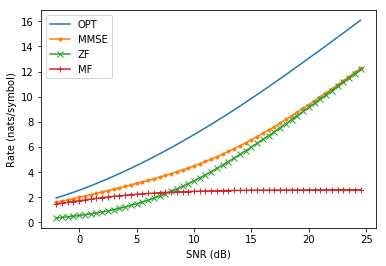

In [14]:
# Plot
SNR = 10**(SNR_dB/10)
R_SHANNON = log(1+SNR)
line_style = {'OPT':'-','MMSE':'.-','ZF':'x-','MF':'+-'}
for rx in ['OPT'] + RX_LIST:
    plot(SNR_dB,RX[rx],line_style[rx],label=rx)
xlabel('SNR (dB)')
ylabel('Rate (nats/symbol)')
legend(loc='upper left')

              MF      MMSE       OPT        ZF
SNR_dB                                        
-2.0    1.452965  1.595406  1.942147  0.361071
-1.5    1.525026  1.693721  2.087728  0.402266
-1.0    1.595733  1.794029  2.239815  0.447818
-0.5    1.664692  1.896097  2.398315  0.498110
 0.0    1.731552  1.999716  2.563112  0.553544
 0.5    1.796004  2.104701  2.734078  0.614535
 1.0    1.857789  2.210907  2.911073  0.681513
 1.5    1.916701  2.318234  3.093949  0.754911
 2.0    1.972587  2.426634  3.282556  0.835166
 2.5    2.025343  2.536120  3.476742  0.922712


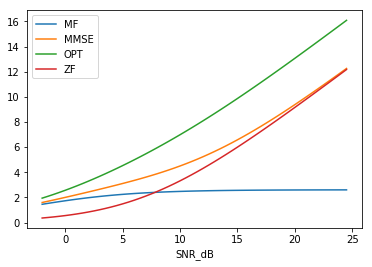

In [15]:
import pandas as pd
df = pd.DataFrame(RX)
df['SNR_dB'] = SNR_dB
df.set_index(["SNR_dB"],inplace=True)
print df.head(10)
df.plot()
df1=df

## Semi-generic implementation

In [16]:
#sim = dict()
#sim['SNR_dB'] = SNR_dB
#sim['RX_LIST'] = ['OPT','MMSE','ZF','MF']
#sim['info_rate_func'] = info_rate_rx

def run_sim(sim):
    info_rate_func = sim['info_rate_func']
    
    #SNR_dB = arange(-2,25,0.5)
    SNR_dB = sim['SNR_dB']

    R_ZEROS = zeros( len(SNR_dB) )
    #RX_LIST = ['OPT','MMSE','ZF','MF']
    RX_LIST = sim['RX_LIST']
    RX = {rx:array(R_ZEROS) for rx in RX_LIST}

    for snr_index in range(len(SNR_dB)):
        #print "SNR = " + str(SNR_dB[snr_index]) + " dB"
        SNR = 10**(SNR_dB[snr_index]/10)    #signal to noise ratio (linear)        
        sigma2 = 1.0/SNR            #noise variance

        Sigma_Z = sigma2 * identity(NN)

        # create communication system
        comsys = {'H':H,'Sigma_Z':Sigma_Z}

        # compute info rates for differnt receivers
        comsys_ = dict(comsys)
        for rx in RX_LIST:
            # compute receiver matrix 
            G_RX = rx_matrix(rx,H,Sigma_Z)
            #print rx
            #print G_RX
            #comsys_['H'] = G_RX.dot(comsys['H']) # WRONG, bec G_RX has be applied to noise too
            comsys_['G_RX'] = G_RX
            R = info_rate_func(comsys=comsys_,rx=rx)
            RX[rx][snr_index] = R
            #print 'R = %.2f' %(R)
    
    return RX


In [17]:
sim = dict()
sim['SNR_dB'] = SNR_dB
sim['RX_LIST'] = ['OPT','MMSE','ZF','MF']
sim['info_rate_func'] = info_rate_rx
RX = run_sim(sim)

              MF      MMSE       OPT        ZF
SNR_dB                                        
-2.0    1.452965  1.595406  1.942147  0.361071
-1.5    1.525026  1.693721  2.087728  0.402266
-1.0    1.595733  1.794029  2.239815  0.447818
-0.5    1.664692  1.896097  2.398315  0.498110
 0.0    1.731552  1.999716  2.563112  0.553544
 0.5    1.796004  2.104701  2.734078  0.614535
 1.0    1.857789  2.210907  2.911073  0.681513
 1.5    1.916701  2.318234  3.093949  0.754911
 2.0    1.972587  2.426634  3.282556  0.835166
 2.5    2.025343  2.536120  3.476742  0.922712


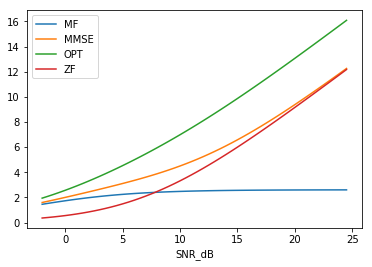

In [18]:
import pandas as pd
df = pd.DataFrame(RX)
df['SNR_dB'] = SNR_dB
df.set_index(["SNR_dB"],inplace=True)
print df.head(10)
df.plot()
df2=df

## Compare both implementations

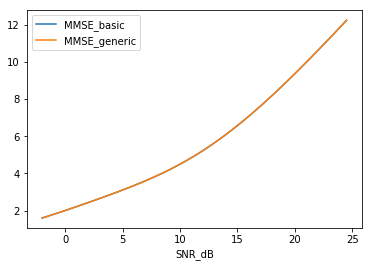

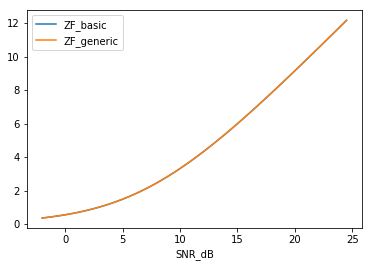

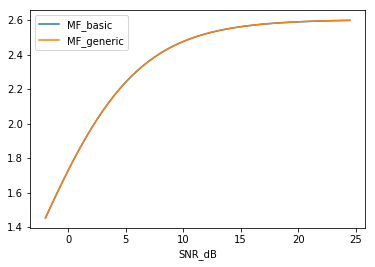

In [19]:
for key in RX_LIST:
    pd.DataFrame.join(df1[[key]],df2[[key]],lsuffix='_basic',rsuffix='_generic').plot()

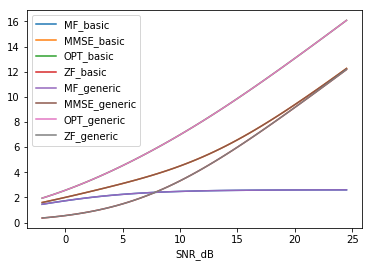

In [20]:
pd.DataFrame.join(df1,df2,lsuffix='_basic',rsuffix='_generic').plot()